# Crear una herramienta de script

Este tutorial fue desarrollado originalmente por el equipo Learn de Esri. 
Puede encontrar la versión oficial actualizada en esta ubicación [https://learngis.maps.arcgis.com/home/item.html?id=24e13f2f4fe8453b9d1107e1f5b1d3cf](https://learngis.maps.arcgis.com/home/item.html?id=24e13f2f4fe8453b9d1107e1f5b1d3cf).
Puede encontrar otros tutoriales en la galería de tutoriales [https://learn.arcgis.com/en/gallery/](https://learn.arcgis.com/en/gallery/).

Con su código Python escrito, ahora puede modificarlo ligeramente para crear una [herramienta de script](https://pro.arcgis.com/en/pro-app/latest/arcpy/geoprocessing_and_python/a-quick-tour-of-creating-script-tools.htm). Una herramienta de script permitirá a cualquier persona con ArcGIS Pro y la extensión Spatial Analyst ejecutar el script de Python que ha creado sin ningún conocimiento de Python o Notebooks. Se verá y funcionará como cualquier otra herramienta de geoprocesamiento en ArcGIS.  

Convertir un script en una herramienta de script permite a los no programadores utilizar su flujo de trabajo de análisis.

Hay varios pasos para crear una herramienta de guión:  

1. Modificar el código para recibir entradas de la herramienta de script.
2. Exportar el contenido del cuaderno a un archivo Python (.py). 
3. Crear una caja de herramientas.
4. Crear una herramienta de script en la caja de herramientas. 
5. Establezca los parámetros de la herramienta.  
6. Documente la herramienta.
7. Conectar la herramienta al script Python.
8. Ejecute la herramienta.

### Modificar el código para su uso en la herramienta de script  

Primero, harás algunas modificaciones para permitir que la herramienta de script pase valores de parámetros al código Python. Una vez hecho esto, exportarás el código modificado a un archivo Python y lo utilizarás para crear la herramienta de script.

En el script original, estableces varias variables al principio del código. Estas variables son `carpeta_img_antes` y `carpeta_img_despues,` que contienen las ubicaciones de las carpetas que contienen las imágenes a procesar, y `carpeta_salida_final`, que contiene la ruta a la carpeta donde se escribirán los archivos de salida. Estas variables deben cambiarse para aceptar la entrada cuando se ejecuta la herramienta de script.  

El código del notebook anterior se incluye a continuación. Lo editarás en este notebook, exportarás el script .py desde este notebook y continuarás siguiendo las instrucciones aquí para configurar la herramienta de script.

Utilizará el método [GetParameterAsText](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/getparameterastext.htm) para establecer estas variables pasando valores desde la herramienta de script. Para ello, configure los valores de las tres variables de ruta de datos como parámetros de script. El valor del índice se utiliza para que coincida con el valor pasado desde la herramienta de script al script cuando se ejecuta. Los números de índice corresponden al orden de los parámetros en la herramienta GUI, de arriba a abajo, comenzando con un valor de índice de 0, y aumentando en uno para cada parámetro. El primer parámetro en el script Python, con `arcpy.GetParameterAsText(0),` obtendrá su valor del primer parámetro de la herramienta GUI.

En la celda de abajo, las líneas para establecer las tres variables han sido comentadas, y se han añadido nuevas líneas, estableciendo las variables usando `GetParameterAsText(valor índice)`.

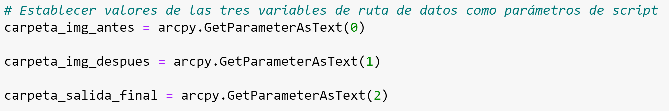

Estos son los únicos cambios que hay que hacer en el código para poder utilizarlo en una herramienta de script.  

In [ ]:
# Importar
import os
from glob import glob
import arcpy
from arcpy.sa import *

# Establecer valores de las tres variables de ruta de datos como parámetros de script
carpeta_img_antes = arcpy.GetParameterAsText(0)

carpeta_img_despues = arcpy.GetParameterAsText(1)

carpeta_salida_final = arcpy.GetParameterAsText(2)

def crear_sen2_variables_bandas(in_folder):
    """Una función que crea variables de banda para imágenes Sentinel-2 dada la carpeta con todas las imágenes de banda."""
    
    # Usa arcpy.AddMessage como print() para imprimir en los mensajes de geoprocesamiento de ArcGIS
    arcpy.AddMessage("Creando variables para bandas de imagen...")

    # Obtener una lista de los archivos jpg2000 de la carpeta de entrada y almacenarla en una lista
    lista_bandas = glob(in_folder + "/*.jp2")

    # Utilice la comprensión de listas (list_comprehension) para obtener los archivos de la lista_band que corresponden a los nombres específicos de los archivos de banda de Sentinel-2.
    Blue = [x for x in lista_bandas if x.endswith("B02.jp2")][0]
    Green = [x for x in lista_bandas if x.endswith("B03.jp2")][0]
    Red = [x for x in lista_bandas if x.endswith("B04.jp2")][0]
    Red_Edge_1 = [x for x in lista_bandas if x.endswith("B05.jp2")][0]
    NIR = [x for x in lista_bandas if x.endswith("B08.jp2")][0]
    SWIR2 = [x for x in lista_bandas if x.endswith("B12.jp2")][0]

    #  Devuelve las variables de banda
    return Blue, Green, Red, Red_Edge_1, NIR, SWIR2

# llamar a la función create_sen2_band_variables en la carpeta que contiene las imágenes posteriores
despues_Blue, despues_Green, despues_Red, despues_Red_Edge_1, despues_NIR, despues_SWIR2 = crear_sen2_variables_bandas(carpeta_img_despues)

# imprime un par de bandas para ver los resultados
print(despues_Red)  # imprimir el recorrido de la banda roja
print(despues_NIR)  # imprimir el recorrido de la banda NIR

# crear la imagen compuesta, almacenando el resultado en memoria
arcpy.CompositeBands_management(in_rasters=f"{despues_NIR};{despues_Red};{despues_Green}",
                                out_raster=r"memory\composicion_img_despues")

# crea la función para calcular SWI
def calcular_swi(red_edge1_band, swir2_band):
    """Crear una función que calcule el SWI para la imagen de entrada dada."""
    
    arcpy.AddMessage("\nInicio del cálculo SWI...")
    
    # Calcular el SWI - Índice de Agua de Sentinel-2
    # Fórmula SWI = (Red_Edge1 - SWIR2) / (Red_Edge1 + SWIR2)
    
    # Crear una variable para almacenar el cálculo del numerador
    # usando la herramienta Float de arcpy spatial analyst para crear un raster con valores de celda en coma flotante
    Numerador = arcpy.sa.Float(Raster(red_edge1_band) - Raster(swir2_band))
    
    # Crear una variable para almacenar el cálculo del denominador
    # usando la herramienta Float del analista espacial arcpy para crear un raster con valores de celda en coma flotante
    Denominador = arcpy.sa.Float(Raster(red_edge1_band) + Raster(swir2_band))
    
    # Usa la herramienta Divide del analista espacial arcpy para dividir el numerador y el denominador 
    SWI = arcpy.sa.Divide(Numerador, Denominador)

    # devuelve los resultados
    return SWI
    
    arcpy.AddMessage("SWI Generado Exitosamente")

# crea la función para calcular NDWI
def calcular_ndwi(green_band, nir_band):
    """Crear una función que calcule el NDWI para la imagen de entrada dada."""

    arcpy.AddMessage("\nInicio del cálculo NDWI...")
    
    # Calcular el NDWI - Índice Normalizado de Diferencia de Agua
    # Fórmula NDWI = (Verde - NIR) / (Verde + NIR)

    # Crear una variable para almacenar el cálculo para el numerador
    # usando la herramienta Float del analista espacial arcpy para crear un raster con valores de celda en coma flotante
    Num = arcpy.sa.Float(Raster(green_band) - Raster(nir_band))
    
    # Crear una variable para almacenar el cálculo del denominador
    # usando la herramienta Float del analista espacial arcpy para crear un raster con valores de celda en coma flotante
    Denom = arcpy.sa.Float(Raster(green_band) + Raster(nir_band))
    
    # Usa la herramienta Divide del analista espacial arcpy para dividir el numerador y el denominador 
    NDWI = arcpy.sa.Divide(Num, Denom)
    
    # devuelve los resultados
    return NDWI
    
    arcpy.AddMessage("NDWI Generado Exitosamente")

# Procesar SWI 
# Crear el raster SWI
swi_despues = calcular_swi(red_edge1_band=despues_Red_Edge_1,
                               swir2_band=despues_SWIR2)

# Crear ruta para el archivo SWI de salida
swi_despues_raster = r"memory\swi_despues_raster"

# Guardar el resultado
swi_despues.save(swi_despues_raster)


# Procesar NDWI 
# Crear el raster NDWI
ndwi_despues = calcular_ndwi(green_band=despues_Green,
                                 nir_band=despues_NIR)

# Crear ruta para el archivo NDWI de salida
ndwi_despues_raster = r"memory\ndwi_despues_raster"

# Guardar el resultado
ndwi_despues.save(ndwi_despues_raster)

def crear_umbral_raster(raster_entrada):
    """Crea una función que umbraliza el raster de entrada y luego la devuelve."""
    
    # Ejecute la función de umbralización de Ostu en el raster de entrada
    calc_umbral = arcpy.sa.Threshold(raster_entrada)
    
    # Devuelve el resultado
    return calc_umbral

# Procesar NDWI 
# Utilizar la función threshold_raster para procesar el raster NDWI
ndwi_despues_umbral_calc = crear_umbral_raster(raster_entrada=ndwi_despues_raster)

# Crear una ruta para el archivo NDWI de salida
ndwi_despues_umbral_raster = r"memory\ndwi_despues_umbral"

# Guardar el raster NDWI umbral
ndwi_despues_umbral_calc.save(ndwi_despues_umbral_raster)

# Crear una capa de trama para el archivo de umbral NDWI para que pueda visualizarse en la pestaña de mapa de resultados
capa_ndwi_despues_umbral = arcpy.MakeRasterLayer_management(ndwi_despues_umbral_raster, 'ndwi_despues_umbral')


# Procesar SWI 
# Usa la función threshold_raster para procesar el raster SWI
swi_despues_umbral_calc = crear_umbral_raster(raster_entrada=swi_despues_raster)

# Crear una ruta para el archivo SWI de salida
swi_despues_umbral_raster = r"memory\swi_despues_umbral"

# Guardar el raster SWI umbral
swi_despues_umbral_calc.save(swi_despues_umbral_raster)

# Crear una capa de trama para el archivo de umbral SWI para que pueda visualizarse en la pestaña de mapa de resultados
capa_swi_despues_umbral = arcpy.MakeRasterLayer_management(swi_despues_umbral_raster, 'swi_despues_umbral')

def crear_raster_confianza_agua(ndwi_umbral_raster, swi_umbral_raster):
    """Cree una función que calcule la suma de dos rásters."""
    
    # Añada los dos rásteres de umbral creando objetos ráster de cada uno y combinándolos mediante el operador de suma +.
    raster_confianza_agua = Raster(ndwi_umbral_raster) + Raster(swi_umbral_raster)

    # Devuelve el resultado
    return raster_confianza_agua

# Llame a la función create_water_confidence_raster
raster_agua_confianza_despues = crear_raster_confianza_agua(ndwi_umbral_raster=ndwi_despues_umbral_raster, 
                                                         swi_umbral_raster=swi_despues_umbral_raster)

# Crear una ruta para el archivo raster de confianza del agua de salida
ruta_raster_agua_confianza_despues = r"memory\raster_agua_confianza_despues"

# Guardar la trama de confianza del agua en un archivo de la memoria
raster_agua_confianza_despues.save(ruta_raster_agua_confianza_despues)

# Crear los valores de reasignación para establecer cualquier píxel con el valor de 1 a 0.
remap_value = RemapValue([[1, 0]])

# Reclasificar la máscara de agua
mascara_agua_despues_reclas = Reclassify(in_raster=ruta_raster_agua_confianza_despues, 
                                      reclass_field="value", 
                                      remap=remap_value)

# Crear una ruta para el archivo de máscara de agua de salida
mascara_agua_despues_reclas_raster = r"memory\mascara_agua_despues_alta_confianza"

# Guardar la máscara de agua
mascara_agua_despues_reclas.save(mascara_agua_despues_reclas_raster)

# Paso 1: crear las variables de banda 
antes_Blue, antes_Green, antes_Red, antes_Red_Edge_1, antes_NIR, antes_SWIR2 = crear_sen2_variables_bandas(carpeta_img_antes)


# Paso 2: Crear una imagen compuesta infrarroja en falso color 
# crear una imagen compuesta, almacenando el resultado en memoria
arcpy.CompositeBands_management(in_rasters=f"{antes_NIR};{antes_Red};{antes_Green}",
                                out_raster=r"memory\composicion_img_antes")

# Paso 3: crear índices 
# crear el raster SWI
swi_antes = calcular_swi(red_edge1_band=antes_Red_Edge_1,
                                swir2_band=antes_SWIR2)

# Crear ruta para guardar archivo SWI antes
swi_antes_raster = r"memory\swi_antes_raster"

# Guardar el resultado en un archivo
swi_antes.save(swi_antes_raster)

# crear una capa ráster para el archivo de umbral SWI para que pueda visualizarse en la pestaña de mapa de resultados.
capa_swi_antes = arcpy.MakeRasterLayer_management(swi_antes_raster, 'swi_antes')

# crear el raster NDWI
ndwi_antes = calcular_ndwi(green_band=antes_Green,
                                  nir_band=antes_NIR)

# Crear ruta para guardar archivo NDWI antes
ndwi_antes_raster = r"memory\ndwi_antes_raster"

# Guardar el resultado en un archivo
ndwi_antes.save(ndwi_antes_raster)

# crear una capa ráster para el archivo de umbral NDWI para que pueda visualizarse en la pestaña de mapa de resultados.
capa_ndwi_antes = arcpy.MakeRasterLayer_management(ndwi_antes_raster, 'ndwi_antes')


# Paso 4: índices de umbral 
# Umbral para NDWI
ndwi_antes_umbral_calc = crear_umbral_raster(raster_entrada=ndwi_antes_raster)

# crear ruta para archivo NDWI de salida
ndwi_antes_umbral_raster = r"memory\ndwi_antes_umbral"

# guardar el raster de umbrales NDWI
ndwi_antes_umbral_calc.save(ndwi_antes_umbral_raster)

# crear una capa raster para el archivo de umbral NDWI para que se pueda ver en la pestaña de mapa de resultados.
capa_ndwi_antes_umbral = arcpy.MakeRasterLayer_management(ndwi_antes_umbral_raster, 'ndwi_antes_umbral')

# Umbral para SWI
swi_antes_umbral_calc = crear_umbral_raster(raster_entrada=swi_antes_raster)

# crear ruta para archivo SWI de salida
swi_antes_umbral_raster = r"memory\swi_antes_umbral"

# guardar el raster de umbrales SWI
swi_antes_umbral_calc.save(swi_antes_umbral_raster)

# crear una capa raster para el archivo de umbral SWI para que se pueda ver en la pestaña de mapa de resultados.
capa_swi_antes_umbral = arcpy.MakeRasterLayer_management(swi_antes_umbral_raster, 'swi_antes_umbral')


# Paso 5: calcular el raster de confianza 
# crear raster de confianza de agua
raster_agua_confianza_antes = crear_raster_confianza_agua(ndwi_umbral_raster=ndwi_antes_umbral_raster, 
                                                         swi_umbral_raster=swi_antes_umbral_raster)

# Crear una ruta para el archivo raster de confianza del agua de salida
ruta_raster_agua_confianza_antes = r"memory\raster_agua_confianza_antes"

# Guardar el raster de confianza del agua en un archivo de la memoria
raster_agua_confianza_antes.save(ruta_raster_agua_confianza_antes)

# Paso 6: extraer los pixeles de agua 
# crear el valor remap para establecer cualquier pixel con el valor de 1 a 0.
remap_value = RemapValue([[1, 0]])

# reclasificar la máscara de agua
mascara_agua_antes_reclas = Reclassify(in_raster=ruta_raster_agua_confianza_antes, 
                                      reclass_field="value", 
                                      remap=remap_value)

# Crear una ruta para el archivo de máscara de agua de salida
mascara_agua_antes_reclas_raster = r"memory\mascara_agua_antes_alta_confianza"

# Guardar la máscara de agua
mascara_agua_antes_reclas.save(mascara_agua_antes_reclas_raster)

# Usando objetos raster, resta la máscara de agua antes de la máscara de agua despues
area_inundada_calc = Raster(mascara_agua_despues_reclas) - Raster(mascara_agua_antes_reclas)

# Crear una ruta para área_inundada_calc
raster_area_inundada_calc = r"memory\area_inundada_calc"

# Guardar el raster area_inundada_calc
area_inundada_calc.save(raster_area_inundada_calc)

# Reclasificar el área de inundación final 

# Crear las listas de valores remap
valor_remap_final = RemapValue([[-2, "NoData"], [0, "NoData"]])

# Reclasificar la máscara de agua
area_inundada_final = Reclassify(in_raster=area_inundada_calc, 
                                reclass_field="value", 
                                remap=valor_remap_final)

# Crear ruta para el archivo tif de salida del área inundada
area_inundada_final_raster = os.path.join(carpeta_salida_final, "Area_Inundada_Final_Raster.tif")

# Guardar el área inundada final en un archivo tif
area_inundada_final.save(area_inundada_final_raster)

# Crear ruta para salida de archivo de polígono de área inundada
area_inundada_final_poly = os.path.join(carpeta_salida_final, "Area_Inundada_Final_Poly.shp")

# Convertir para poligono
arcpy.RasterToPolygon_conversion(in_raster=area_inundada_final, 
                                 out_polygon_features=area_inundada_final_poly, 
                                 simplify="NO_SIMPLIFY", 
                                 raster_field="Value")

"""
# Obtener el proyecto ArcGIS Pro actualmente abierto
aprx = arcpy.mp.ArcGISProject("current")
# Obtener el Mapa
m = aprx.listMaps("Map")[0]
# Obtener una lista de las capas del mapa
capas = m.listLayers()
# Comprueba cada capa para determinar si es una capa temporal, en memoria, 
# y eliminar la capa si lo es.
for capa in capas:
    print(capa.dataSource)
    if "INSTANCE_ID=GPProMemoryWorkspace" in capa.dataSource:
        print("Removing: ", capa.name )
        m.removeLayer(capa)
"""

### Exportar el código a un archivo de script Python  

Para utilizar este código con una herramienta de script, debe exportarlo a un archivo Python (.py).

1. En la cinta de opciones, haga clic en la pestaña **Notebook**.
2. Haga clic en el menú desplegable **Export** y haga clic en **Export to Python File**.
3. Busque la carpeta **C:\ArcGIS_Python\Deteccion_Inundacion**, nombre el archivo Python `Herramienta_Analisis_Inundaciones.py`, y haga clic en **Save**. 

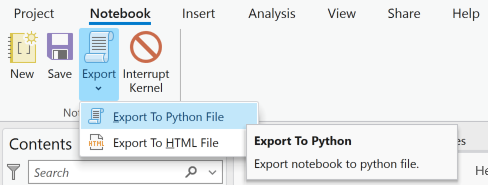

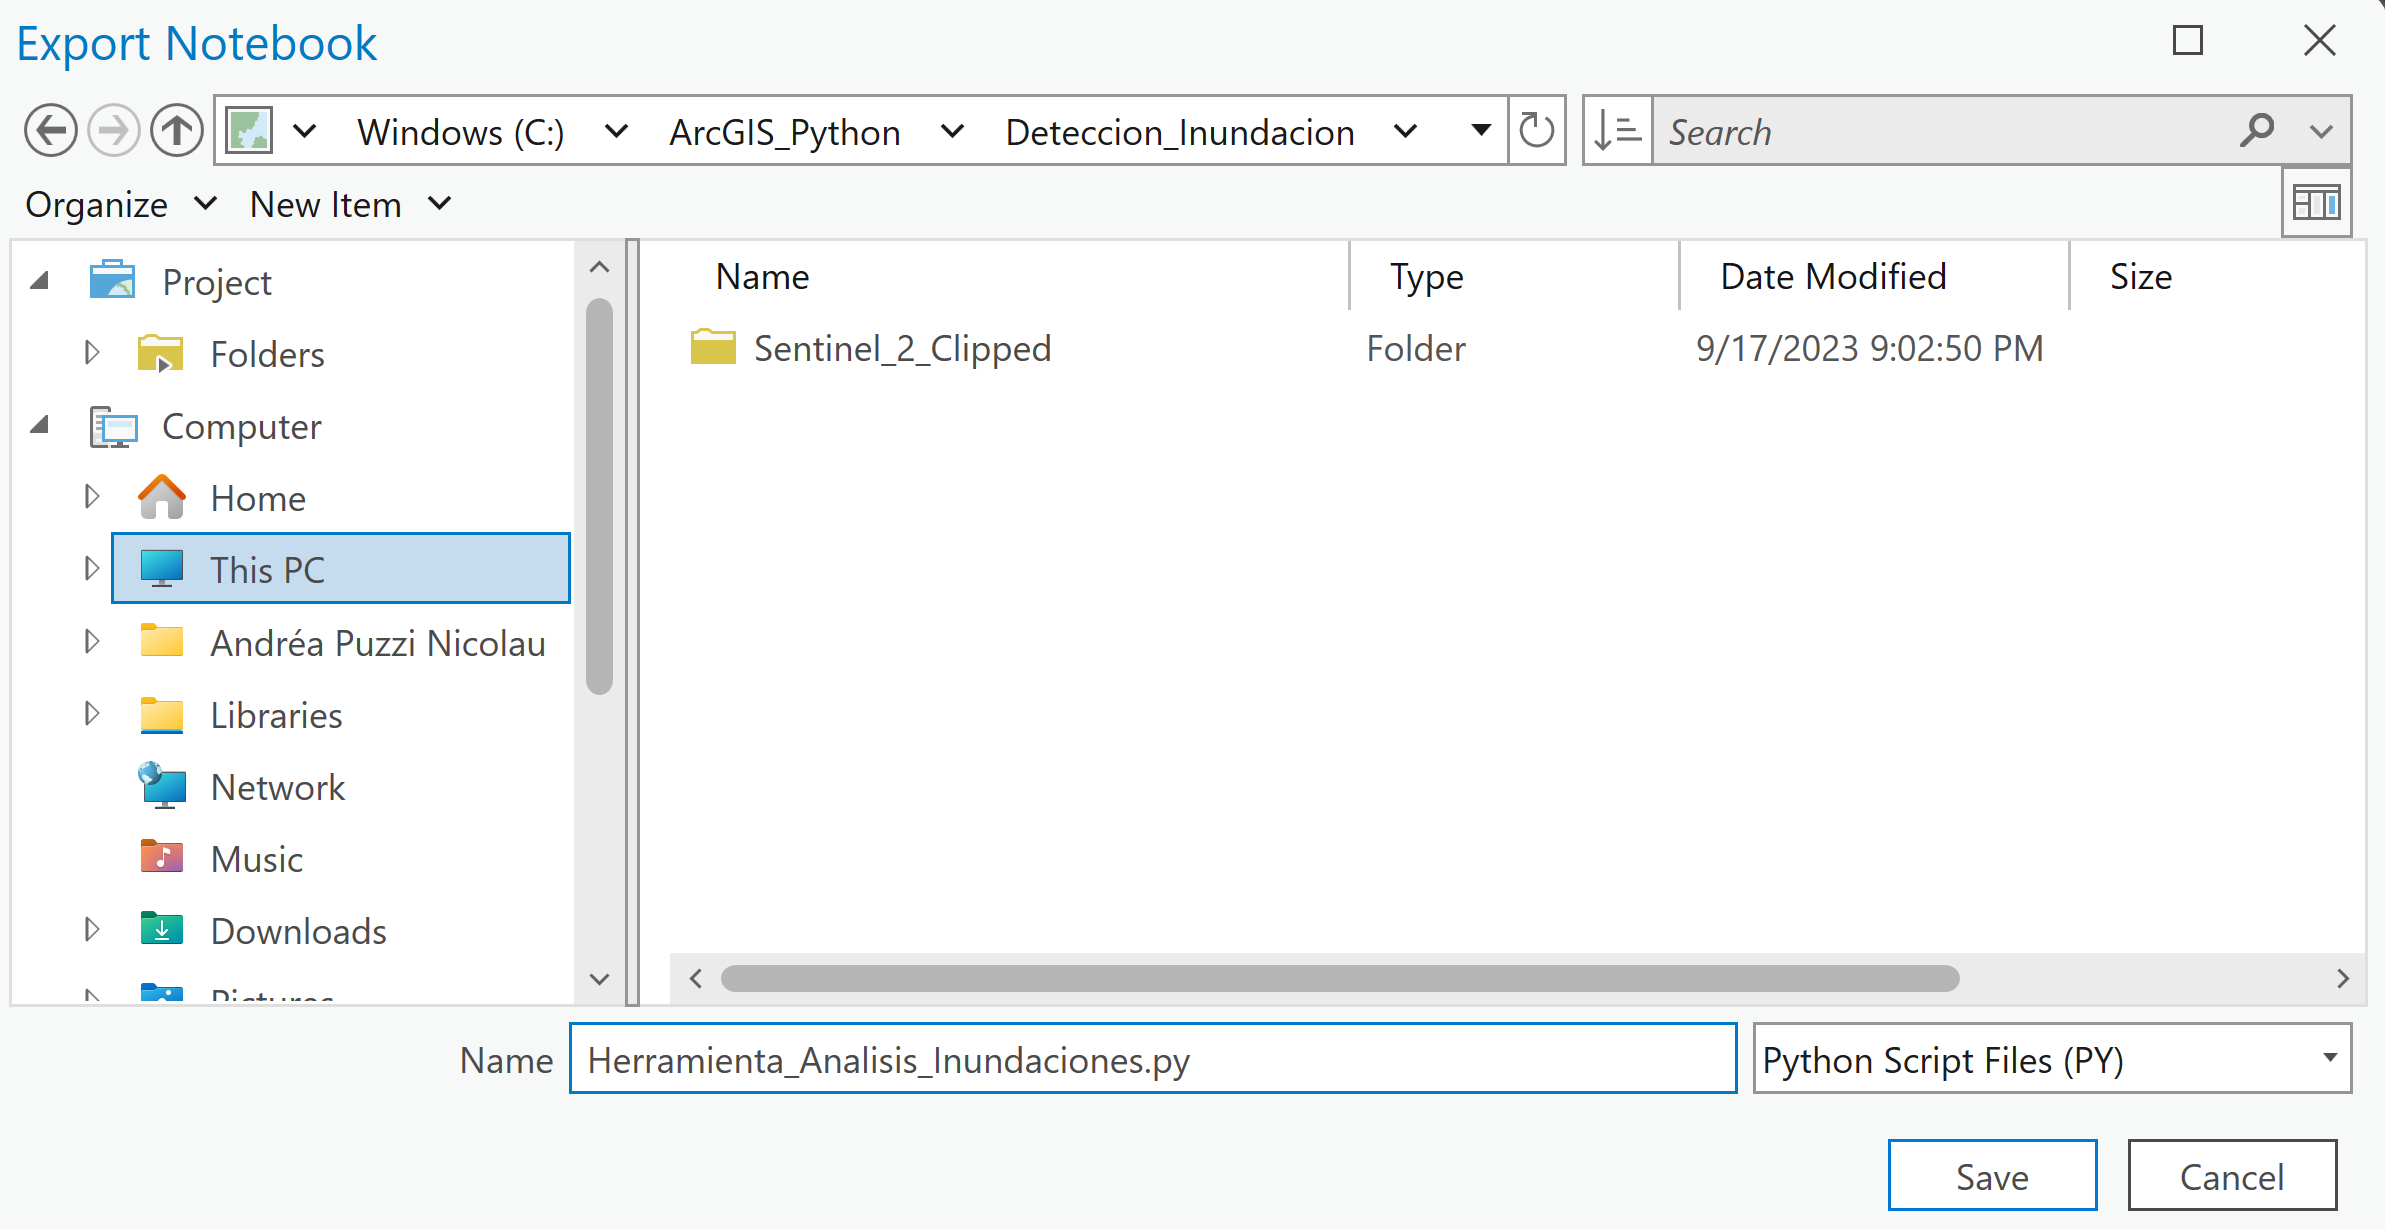

### Crear una caja de herramientas para la herramienta de script  

Las herramientas de script se almacenan en cajas de herramientas. Una vez que haya exportado el código a un archivo Python, el siguiente paso es crear una caja de herramientas donde almacenará su herramienta de script.

1. En la cinta de opciones, haga clic en la pestaña **View** y haga clic en **Catalog Pane**.
2. En el panel **Catalog**, haga clic con el botón derecho en **Folders** y haga clic en **Add Folder Connection**.  
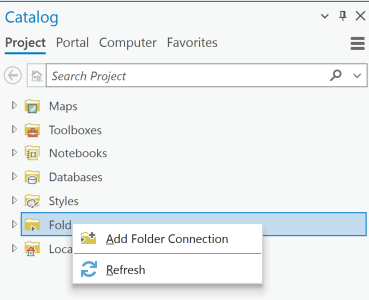

3. Busque la carpeta **C:\ArcGIS_Python\Deteccion_Inundacion**, donde guardó el archivo `Herramienta_Analisis_Inundaciones.py`, y haga clic en **OK**.  

Una conexión de carpeta se añade a su proyecto. Aquí crearás la caja de herramientas.  

4. En el panel **Catalog**, haz clic con el botón derecho en la carpeta, haz clic en **New**, y haz clic en **Toolbox (.atbx)**.  
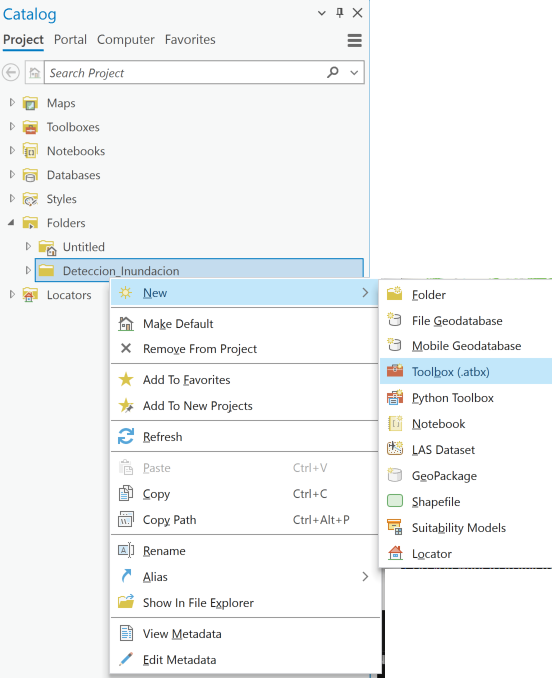

5. Expanda la conexión de la carpeta.  

6. Haga clic con el botón derecho del ratón en **New Toolbox.atbx** y haga clic en **Rename**.  

7. Escriba `Herramientas_personalizadas` como nombre de la caja de herramientas y pulse _Enter_.


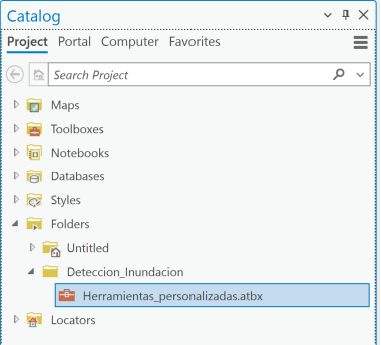

### Crear una herramienta de script  

A continuación, creará la [herramienta de script](https://pro.arcgis.com/en/pro-app/latest/arcpy/geoprocessing_and_python/a-quick-tour-of-creating-script-tools.htm) en la caja de herramientas. Las herramientas de script le permiten ejecutar sus scripts de Python desde una interfaz gráfica como cualquier otra herramienta de geoprocesamiento de ArcGIS.  

Mientras edita las propiedades de la herramienta de script, no podrá desplazarse por la ventana de este bloc de notas. Puede guardar la configuración en la ventana de propiedades de la herramienta de script haciendo clic en **OK** en la parte inferior de la ventana. Puede volver a abrir las propiedades de la herramienta de script haciendo clic con el botón derecho en la herramienta de script de la caja de herramientas y haciendo clic en **Properties**. Puede ser útil copiar las instrucciones de las celdas siguientes en un archivo de texto o en un documento de procesamiento de texto para poder verlas en otra ventana mientras trabaja.

1. En el panel **Catalog**, haga clic con el botón derecho en la caja de herramientas **Herramientas_personalizadas**, haga clic en **New** y haga clic en **Script**.  
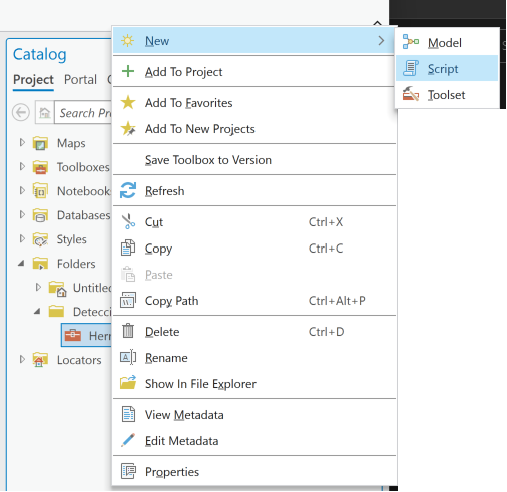

Aparece la ventana **New Script**.  

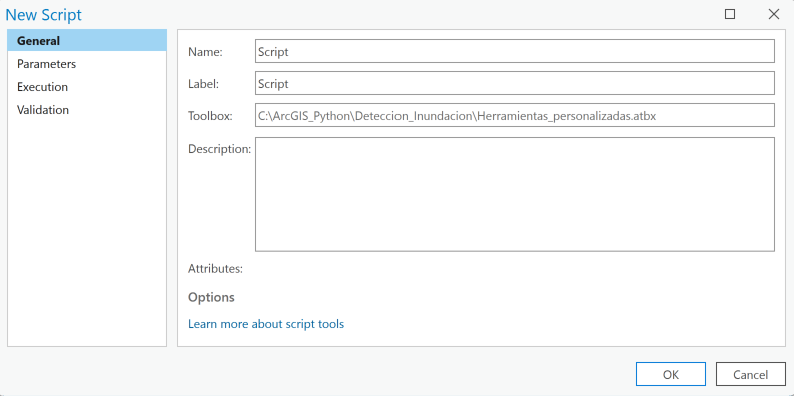

### Configurar la herramienta de script  

La ventana de propiedades de **New Script** tiene varias pestañas. Primero configurará los valores **Name**, **Label** y **Description** de la herramienta de script.

1. En la pestaña **General** de la ventana de propiedades de **New Script**, para **Name**, escriba `HerramientaAnalisisInundaciones`.  
El **Name** de la herramienta de script no puede incluir espacios ni caracteres que no sean letras.  

2. En **Label**, escriba `Herramienta Analisis Inundaciones`.  
La herramienta de script **Label** es una etiqueta de visualización para la herramienta y puede contener espacios.

3. En **Description**, escriba: "Esta herramienta clasificará y extraerá el agua de las imágenes de antes y después. A continuación, calculará el cambio para cuantificar las zonas inundadas tras una inundación. Esta herramienta se utiliza con imágenes multiespectrales Sentinel-2."

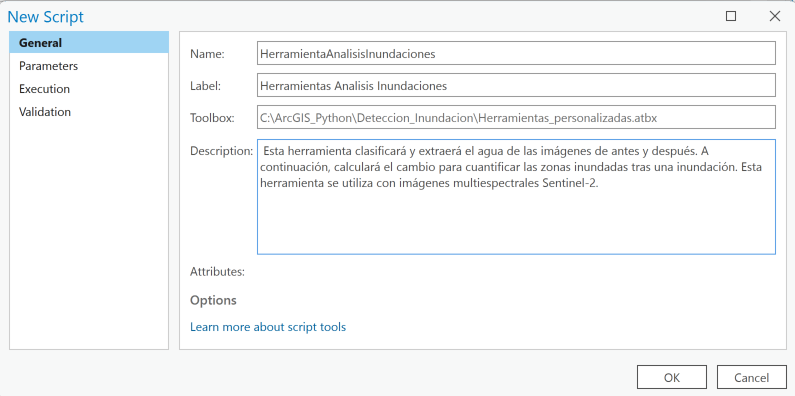

4. Haga clic en **Parameters**.  
La pestaña **Parameters** contiene una tabla donde establecerá los tres parámetros que requiere el script. Para cada parámetro que añada, especificará las opciones **Label**, **Name** y **Data Type** del parámetro.

5. En la pestaña **Parameters**, en la columna **Label**, para la primera fila (0), escriba `Carpeta de imagenes antes`.  

El valor **Label** será la etiqueta para este parámetro en la herramienta de script 

La columna **Name** contiene el texto de **Label** sin espacios.  El **Name** es el nombre del parámetro para utilizar la herramienta con Python.

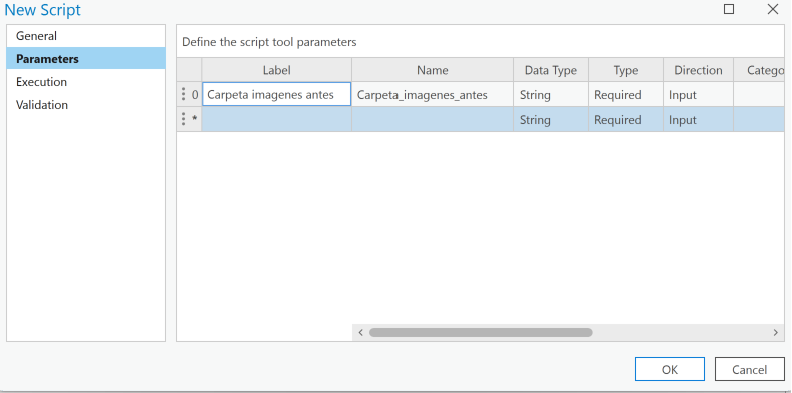

6. En la columna **Data Type** de la primera fila (0), señale el espacio a la derecha de **String**.  
7.  Pulsa el botón **Change Data Type**.
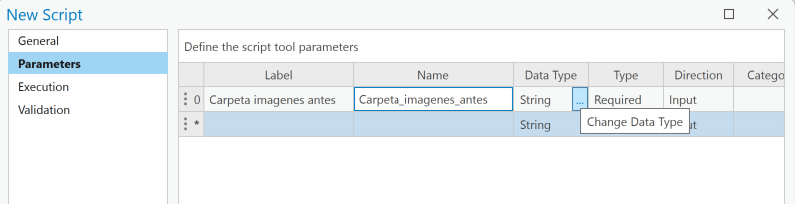  

8. En la ventana **Parameter Data Type**, haga clic en la lista desplegable y elija **Folder**.  
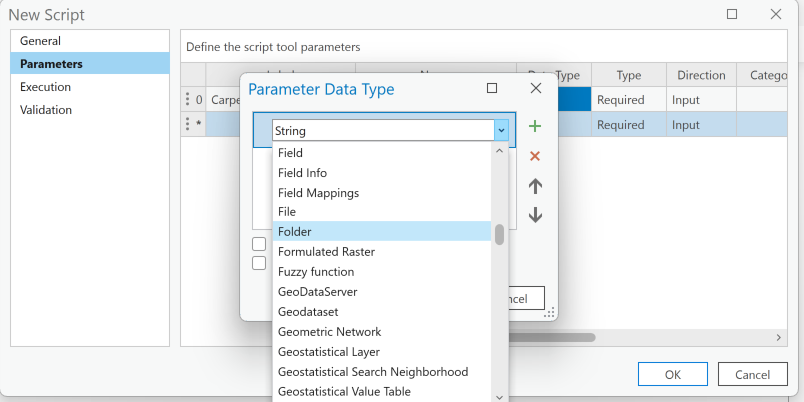

9. Haga clic en **OK**.  

Las herramientas de geoprocesamiento pueden tener muchos tipos diferentes de entradas y salidas.  El script de clasificación de áreas de inundación toma dos carpetas como entradas y escribe la salida en una tercera carpeta, por lo que establecerá el tipo de datos en **Folder** para cada parámetro. 

10. En la pestaña Parameters, en la columna **Label**, para la segunda fila, escriba `Carpeta de imagenes despues`.  
11. Ajuste el **Data Type** a **Folder**.  
12. En la pestaña Parameters, en la columna **Label**, para la tercera fila, escriba `Carpeta de salida final`.  
13. Ajuste el **Data Type** a **Folder**.

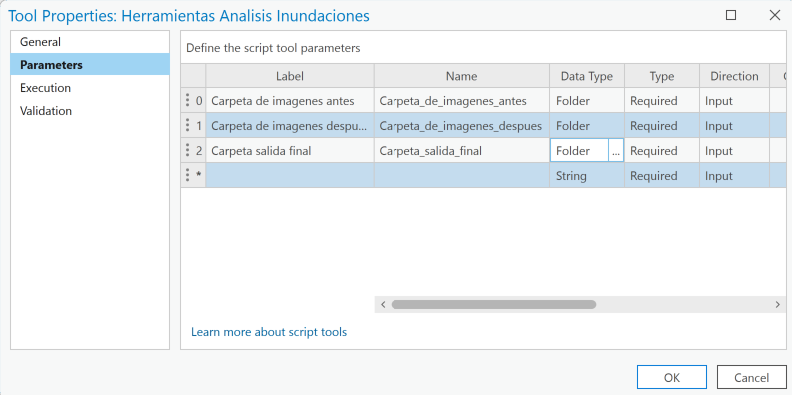

El orden de los parámetros es importante. El orden en esta tabla debe coincidir con el orden que estableciste en el script de Python, usando arcpy.GetParameterAsText. En este caso la variable `carpeta_img_antes` se establece en el primer parámetro, `carpeta_img_despues` se establece en el segundo parámetro, y `carpeta_salida_final` se establece en el tercer parámetro.  

Ahora que ha establecido los parámetros de la herramienta de script, puede abrir la herramienta y ver cómo se ve.

14. En la parte inferior de la ventana de propiedades, haga clic en **OK**.  
Esto guarda las propiedades que has establecido.  

15. En el panel **Catalog**, haga doble clic en **Herramienta Analisis Inundaciones**.
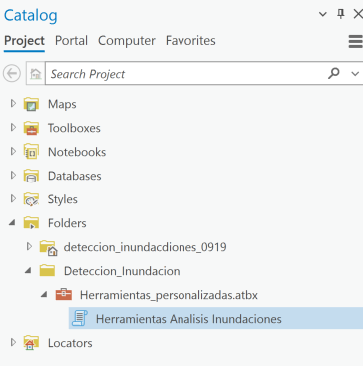

Se abre la herramienta de script. Tiene los parámetros de entrada que usted especificó.  La parte superior de la herramienta muestra el texto de la etiqueta que ha establecido en la pestaña **General**, en el cuadro **Label**.  Los parámetros de entrada están etiquetados con las etiquetas que estableció en la pestaña **Parameters**.
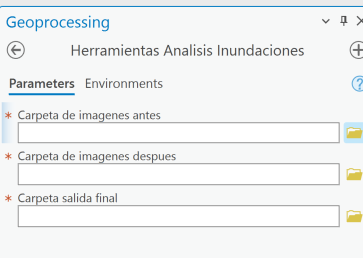

La herramienta no se ejecutará todavía porque no se ha vinculado al archivo de script Python. Añadirás algo de documentación a la herramienta y luego la conectarás al script.

16. Cierre la **Herramienta Analisis Inundaciones**.

### Documentar la herramienta  

Es importante añadir documentación a tu herramienta de script, para que otras personas entiendan cómo utilizarla.  

1. En el panel **Contents**, haga clic con el botón derecho del ratón en **Herramienta Analisis Inundaciones** y haga clic en **Edit Metadata**.
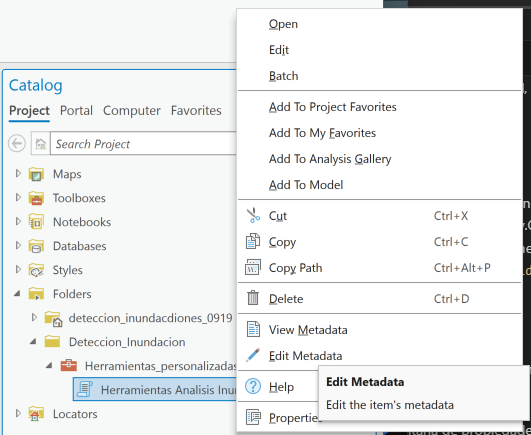

Aparece la pestaña **Metadata**.

En primer lugar, añadirá etiquetas.  

2. En la casilla **Tags**, añada Inundación, Agua, Análisis (o Flood, Water, Analysis).  
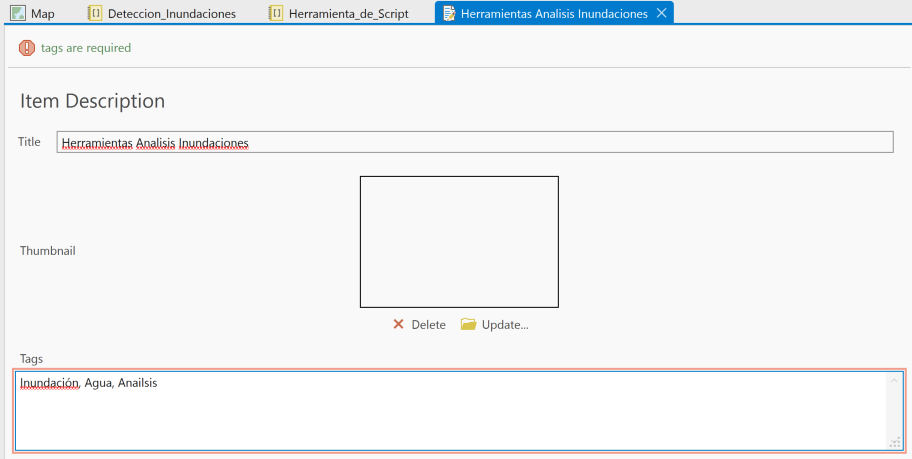

3. Desplácese hacia abajo hasta la sección **Syntax**.

4. En la sección **Syntax**, haga clic en **Carpeta de imagenes antes**.  
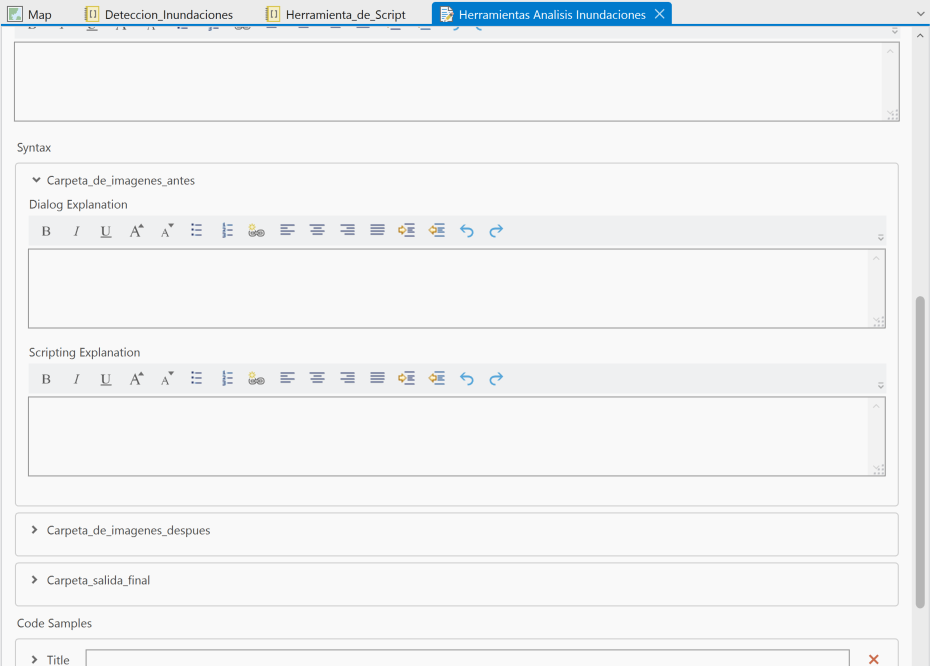 

La sección se expande.

5. En el cuadro **Dialog Explanation**, escriba "Esta es la carpeta que contiene las imágenes previas a la inundación. Esta herramienta requiere imágenes Sentinel-2 que no hayan sido compuestas en una única imagen raster con múltiples bandas. En su lugar, requiere cada banda como un archivo de imagen independiente, ya que normalmente está disponible para su descarga."  

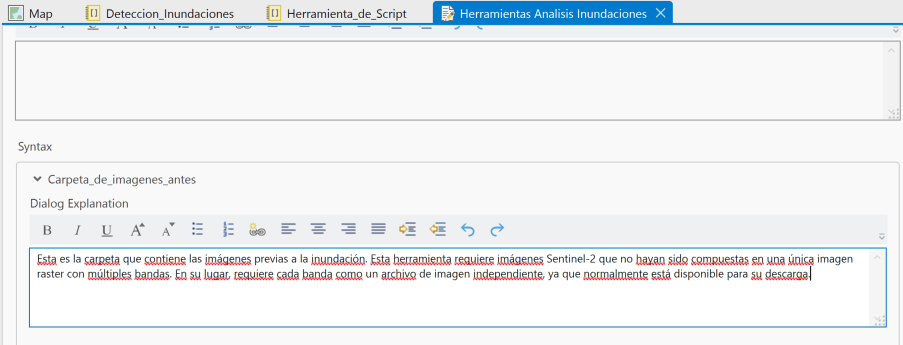

6. Haga clic en **Carpeta_de_imagenes_despues**.  
7. En el cuadro **Dialog Explanation**, escriba "Esta es la carpeta que contiene las imágenes posteriores a la inundación. Esta herramienta requiere imágenes Sentinel-2 que no hayan sido compuestas en una única imagen rasterizada con múltiples bandas. En su lugar, requiere cada banda como un archivo de imagen independiente, tal y como suele estar disponible para su descarga."
8. Haga clic en **Carpeta_de_salida_final**.  
9. En el cuadro **Dialog Explanation**, escriba "Esta es la carpeta donde se guardarán las salidas finales."

10. En la cinta de opciones, en la pestaña **Metadata**, en la sección **Manage Metadata**, haz clic en **Save**.  

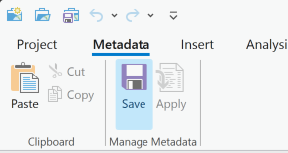

12. Cierre la pestaña de edición de metadatos de **Herramienta Analisis Inundaciones**.  

### Conectar la herramienta al script de Python  

El último paso para que la herramienta sea utilizable es conectar la herramienta script que has configurado al archivo script de Python que has exportado.  

1. En el panel **Catalog**, haga clic con el botón derecho en la **Herramienta Analisis Inundaciones** y haga clic en **Properties**.
2. Haga clic en la pestaña **Execution**.  
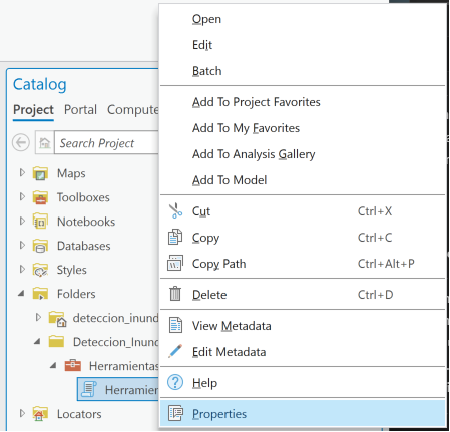

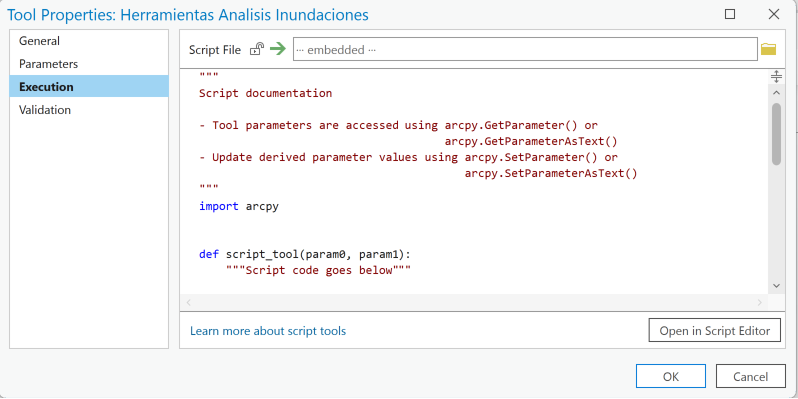

3. Haga clic en el botón browse.  

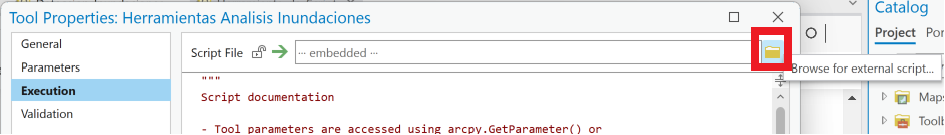

4. Vaya a la carpeta **C:\ArcGIS_Python\Deteccion_Inundacion** donde guardó el archivo de script `Herramienta_Analisis_Inundaciones.py`.  

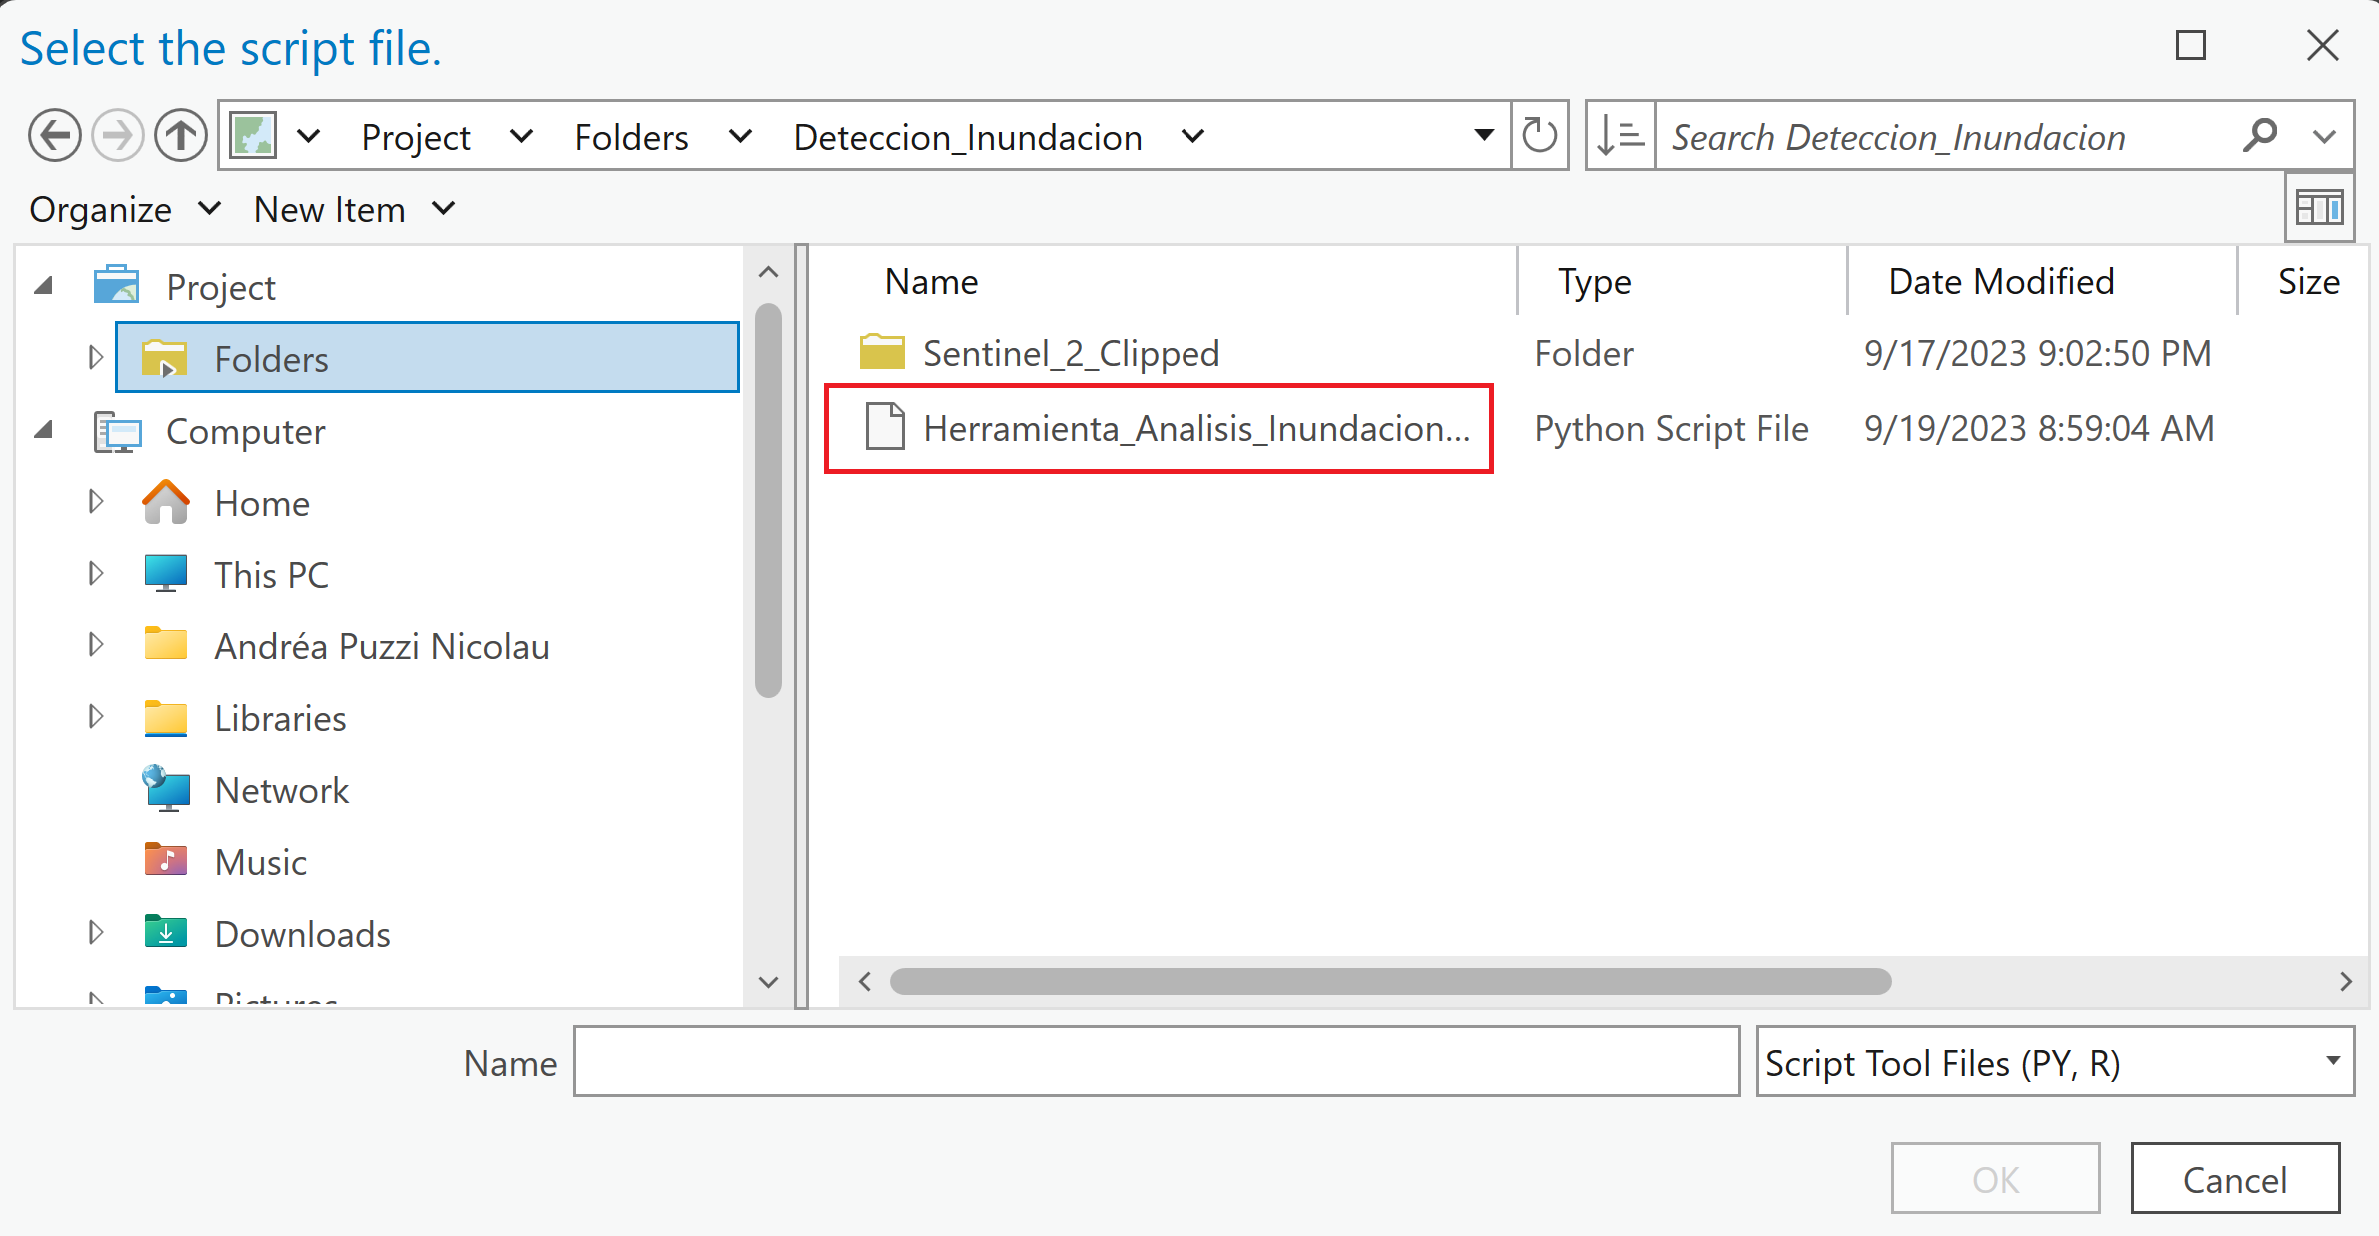

5. Haga clic en `Herramienta_Analisis_Inundaciones.py` y haga clic en **OK**.

El código de ejemplo en el panel **Script File** se sustituye por el código del script `Herramienta_Analisis_Inundaciones.py`.  

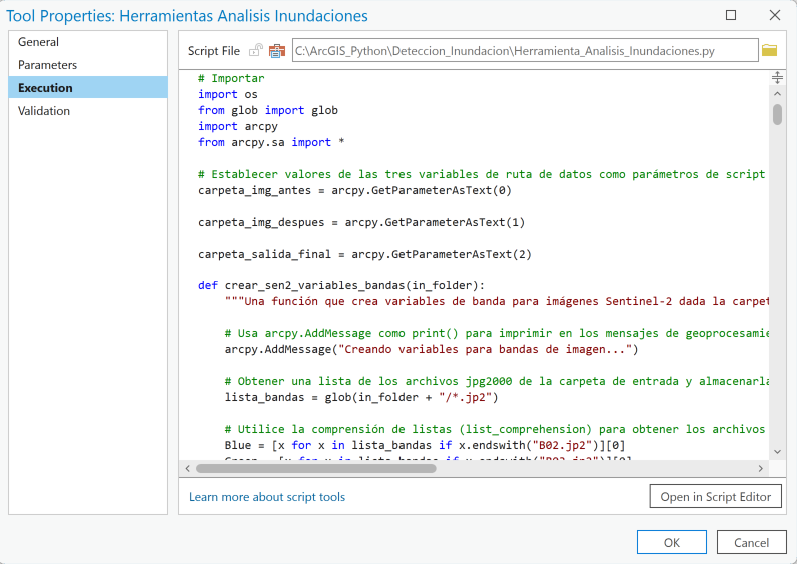

6. Haga clic en **OK**.

Ahora la herramienta de script está configurada para trabajar haciendo referencia al archivo `Herramienta_Analisis_Inundaciones.py` desde su ubicación en el disco duro. Esto es bueno para las pruebas, y para cuando usted no planea compartir la herramienta de script. Sin embargo, si planea compartir esta herramienta con alguien más, debería enviar tanto la caja de herramientas con la herramienta de script como el archivo Python en la estructura de carpetas actual.  

Un método más conveniente para compartir herramientas es incrustar el código en la herramienta de script. Para ello, haga clic en el botón de la caja de herramientas junto a la ruta **Script File**.  
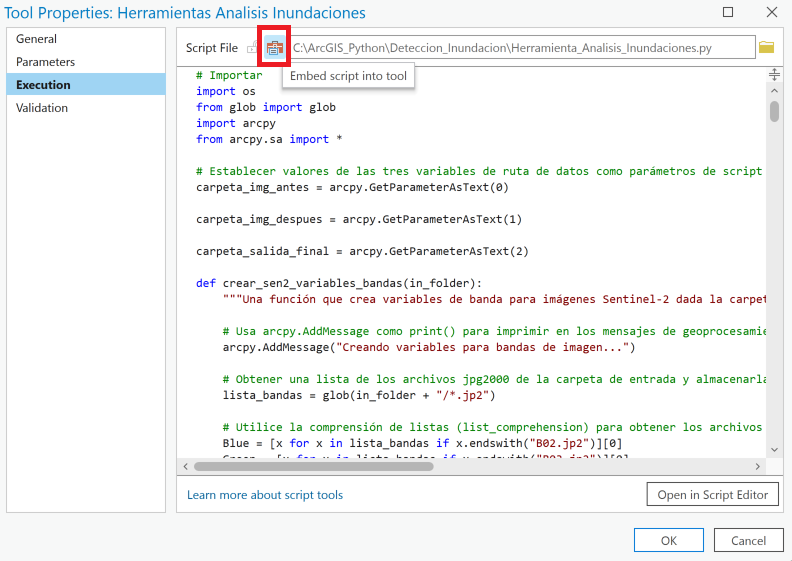

Esto guarda el código en la caja de herramientas, por lo que puede compartir sólo la caja de herramientas, y la herramienta se ejecuta sin necesidad del archivo Python.

### Ejecutar la herramienta  

Ahora que ha terminado de configurar la herramienta, puede ejecutarla.  

1. En el panel **Catalog**, haga doble clic en **Herramienta Analisis Inundaciones**.  
2. En **Carpeta de imagenes antes** haga clic en el botón browser.  

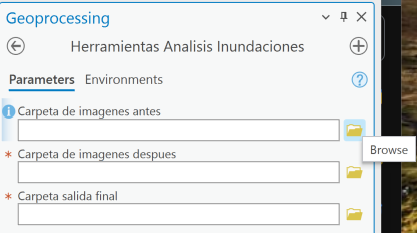

3. Busque la carpeta **C:\ArcGIS_Python\Deteccion_Inundacion\Sentinel_2_Clipped**, haga clic en **Antes**, y haga clic en **OK**.  

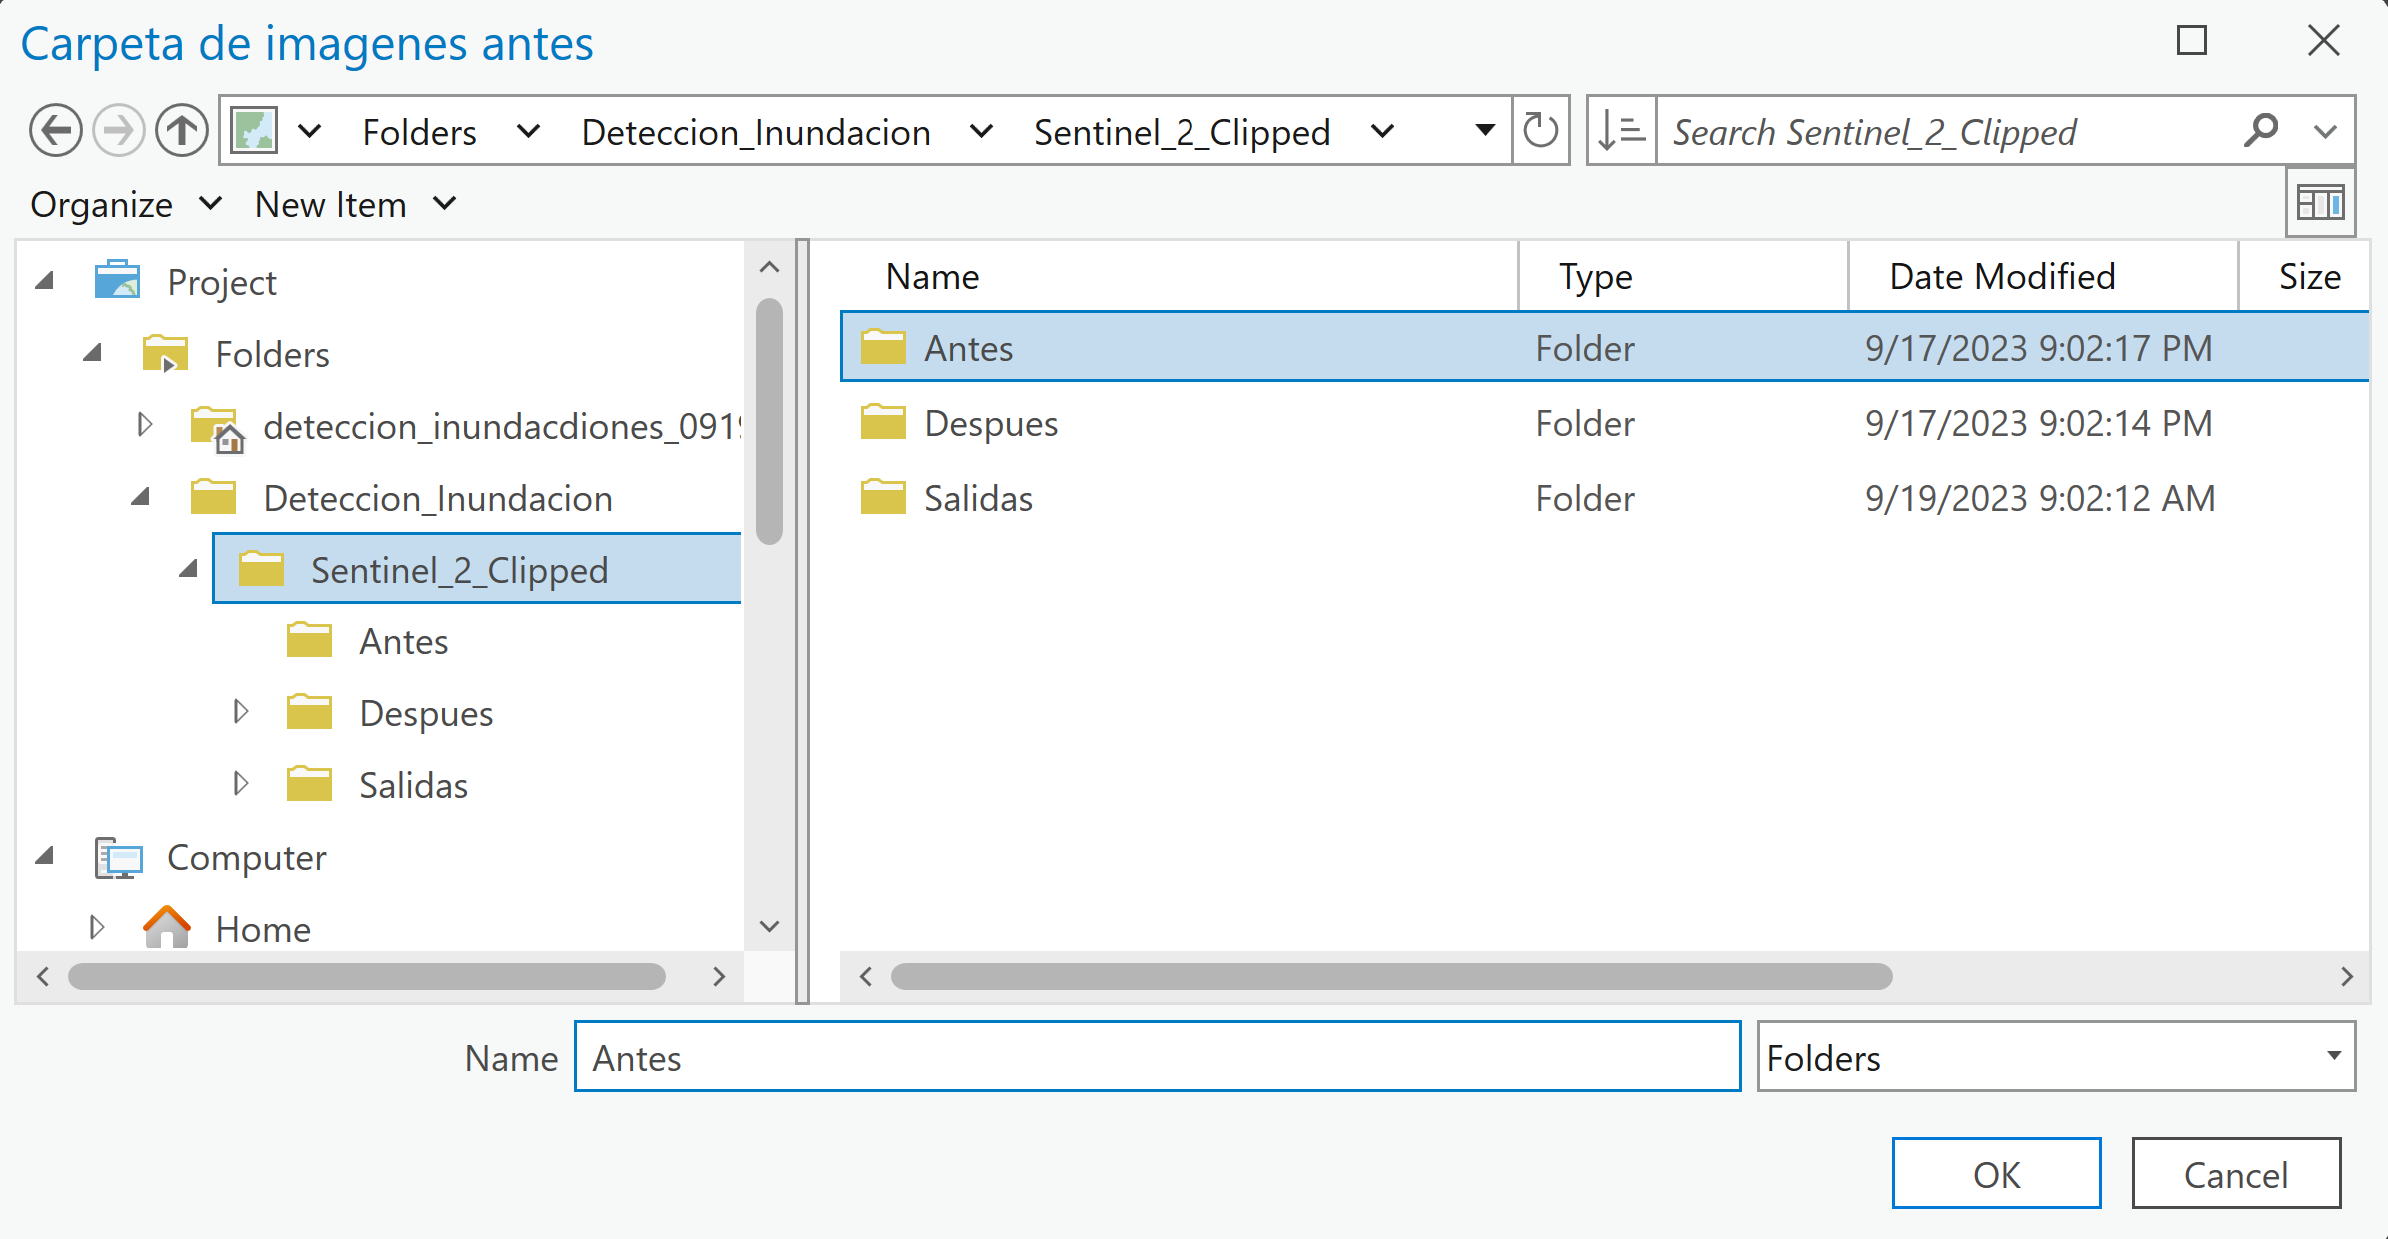

4. Para **Carpeta de imagenes despues**, haga clic en el botón browse y busque la carpeta **Despues**.  
5. En **Carpeta de salida final**, haga clic en el botón browse y vaya a la carpeta **Salidas**.  
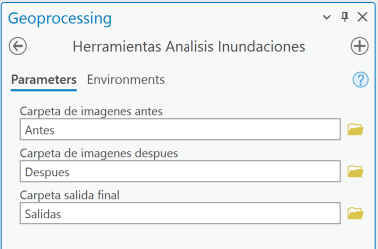

6. Haga clic en **Run**.  
 
La herramienta tardará algún tiempo en ejecutarse.  Cuando termine, la herramienta indicará que se ha ejecutado correctamente.

7. En el panel **Catalog**, vaya a la carpeta **Salidas**.  
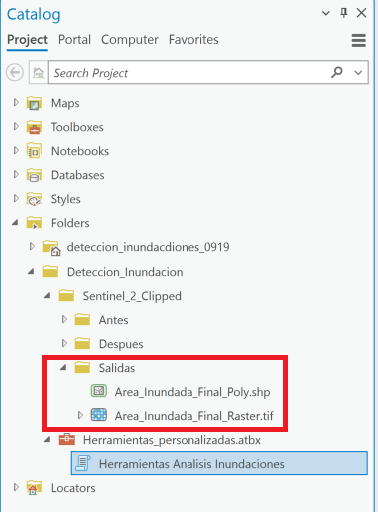

Los archivos **Area_Inundada_Final_Poly.shp** y **Area_Inundada_Final_Raster.tif** se añaden a la carpeta **Salidas**.

Ha creado una herramienta de script a partir de un Notebook.